# 1doc3 Data Science 

## Elaborado por : Juan David García Castro 

### Correo : juancastro97125@gmail.com

#### Fecha : 20 de Mayo de 2021

## En el presente documenta se presenta el desarrollo del proyecto de data science haciendo uso de la base de datos de productos. 

In [26]:
# Librerias 
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import missingno as msno 
import xgboost as xgb 
import gensim
from joblib import dump, load
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_selection import chi2
from sklearn import metrics
from numpy import random
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from bs4 import BeautifulSoup
from sklearn.neural_network import MLPClassifier

# DEFINICIÓN DEL PROBLEMA Y MOTIVACIÓN:

### Este problema consiste en llevar a cabo la clasificación de un producto en una de cuatro clases haciendo uso del título del producto. 

### La motivación detras de este proyecto, con respecto a lo que se lleva a cabo en 1doc3 es aprender a desarrollar y analizar un modelo con el cual dado un texto de un paciente dentro de la plataforma, esta puede predecir, con base en ese texto, una categoría *'general'* de afección que esta presentando dicho paciente y así relacionarlo de forma más eficiente con el médico correspondiente. 

# TAREA#1 : ANÁLISIS DE LOS DATOS

## En este aparatado se desarrollaron 3 procesos principalmente: lectura de los datos (train y val), limpieza de los datos y su posterior análisis exploratorio. 

In [27]:
productos_train = pd.read_csv('Train.csv', header=None, names = ['label','title','is_validated_by_human'], error_bad_lines=False,skiprows=1)
productos_train.head()
productos_val = pd.read_csv('Validation.csv', header=None, names = ['label','title','is_validated_by_human'], error_bad_lines=False,skiprows=1)
productos_val.head()


,label,title,is_validated_by_human
0,TABLETS,Noblex B10t - Pantalla 10.1 Con Windows 8 Casi...,YES;
1,TABLETS,Tablet 7 Pcbox Mdq Intel 1gb 8gb Wifi Camara 2...,YES;
2,"NOTEBOOKS,""Dell I5 7200 3,5ghz,8gb,ssd 256gb, ...",NaN,NaN
3,NOTEBOOKS,Hp 15-ay013la V7s33la I7 6500u 4gb Ram R7 M440...,YES;
4,"NOTEBOOKS,""Notebook Asus X541u Intel I5 7200u ...",NaN,NaN


In [28]:
print('El tamaño de la base de datos de entrenamiento es:',productos_train.shape)
print('El tamaño de la base de datos de validación es:',productos_val.shape)

El tamaño de la base de datos de entrenamiento es: (38705, 3)
El tamaño de la base de datos de validación es: (1245, 3)


In [29]:
productos_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   label                  38705 non-null  object
 1   title                  34442 non-null  object
 2   is_validated_by_human  34440 non-null  object
dtypes: object(3)
memory usage: 907.3+ KB


In [30]:
productos_train.isnull().sum()

label                       0
title                    4263
is_validated_by_human    4265
dtype: int64

In [31]:
productos_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245 entries, 0 to 1244
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   label                  1245 non-null   object
 1   title                  1118 non-null   object
 2   is_validated_by_human  1118 non-null   object
dtypes: object(3)
memory usage: 29.3+ KB


##  A partir de la información anterior se evidencia que existen varios valores nulos dentro de las bases de  datos.

In [32]:
productos_train['label'].value_counts()

TELEPHONES                                                                         12928
CELLPHONES                                                                         10521
NOTEBOOKS                                                                           5707
TABLETS                                                                             5280
TELEPHONES,"Galaxia S7 Caso , E Lv Galaxia S7 - Híbrido [ Rasguño / Po",NO;;;          1
                                                                                   ...  
TELEPHONES,"Samsung Galaxy J7 Prime Negro. Libre, En Excelente Estado.",NO;;;          1
CELLPHONES,"Telefono Inalambrico Philips, Modelo Premium, Muy Comodo.",NO;;;           1
TABLETS,"Tablets Para Niños , Tableta Android 7.1 Para Niños, Panta",YES;;;            1
NOTEBOOKS,"Notebook Hp 15,6 Intel Core I7 6gb Ram Windows10 64bit 1tb",YES;;;          1
CELLPHONES,"Telefono Inalambrico De 5 Bases,alarma,contestador/intercom.",NO;;;        1
Name: label, Length: 

In [33]:
productos_train['title'].value_counts() 

NO";;                                                           2
Galaxy Samsung S10+ Plus                                        1
Telefono Inalambrico Siemens Gigaset A400                       1
iPhone 7 32gb Gris Liberado Comprado  Tienda Apple              1
Motorola Moto G5s Plus                                          1
                                                               ..
 Samsung Galaxy Note 8  64 Gb Nacional                          1
Samsung J5 Usado                                                1
Moto G 4g Xt1040 Nuevos Gtia Oficial Ind Arg Tecnopampa         1
Motorola Moto G7 Power(2019) 64gb 4gb Ram 5000 Mha + Funda      1
3*versin Global Zenfone 4 Selifie Zd553kl 4gb Ram 64gb Rom    1
Name: title, Length: 34441, dtype: int64

In [34]:
productos_train['is_validated_by_human'].value_counts()

NO;;;     29156
YES;;;     5208
NO;;         55
NO;           6
YES;;         6
YES;          3
NO";;         2
YES           1
 4gb          1
NO            1
YES";;        1
Name: is_validated_by_human, dtype: int64

In [35]:
productos_val['label'].value_counts()

NOTEBOOKS                                                                        501
TABLETS                                                                          470
CELLPHONES                                                                       138
TELEPHONES                                                                         9
NOTEBOOKS,"Notebook Inspiron Dell Core I5 5gen°, Ram 8gb, 15,6, 4gb,1tb",YES;      1
                                                                                ... 
NOTEBOOKS,"Notebook Lenovo Intel I3 6100 4gb 500gb Win10 Led Hd 15,6!!!",YES;      1
NOTEBOOKS,"Samsung Np300e5a, Core I3, Hdd 500gb, 4gb Ddr3, Envio Gratis",YES;      1
NOTEBOOKS,"Notebook Hp 1000, 750gb Hd, 8gb Ram, Core I3, Win 8.",YES;              1
TABLETS,"Ipad Mini, Blanco 16 Gb, Con Teclado Externo Bluetooth!",YES;             1
NOTEBOOKS,"Notebook Acer 8gb Ram,1tb De Disco Tomo Celulares En Permuta",YES;      1
Name: label, Length: 131, dtype: int64

In [36]:
productos_val['title'].value_counts()

Macbook Pro 2015 I7  2.2  256ssd  16ram Increible!!             1
2018 Apple Macbook Pro Mr972e/a Touch Bar I7 16gb 512gb         1
Panasonic Kx-tgd224 Inalambrico Dect 6.0 Cuadruple Contestad    1
Celular Libre Motorola Moto G6 32gb 3gb 12mpx + Accesorios      1
Promo! Samsung Galaxy S10+ Plus 128gb 2019! Fact Gtia Anual!    1
                                                               ..
Ipad 2 64gb Todo Original Muy Buen Estado General Con Funda     1
Notebook Hp 14-bs009la Intel Pentium N3710 8gb 1tb              1
Hp Notebook 15.6 Touchscreen I5-8250u 8gb 128gb 18 Cuotas S/    1
Notebook Positivo Bgh Z100 - 14 Celeron 2gb 500gb               1
Notebook Acer Aspire R3-471t-7755 (i7/8gb/1tb) Permuto          1
Name: title, Length: 1118, dtype: int64

In [37]:
productos_val['is_validated_by_human'].value_counts()

YES;    1116
YES        2
Name: is_validated_by_human, dtype: int64

## La columna 'label' contenía más datos de los necesarios y aquellos datos eran los que aparecían como nulos en las columnas de *title* y *is_validated_by_human*. A partir de ello, se procedió a desarrollar un método el cual tomara esos labels erróneos y los pasara a un formato adecuado con respecto a las otras dos columnas. 

In [38]:
bad_labels_train = []
for i in productos_train['label']:
    if len(i) > 10:
        bad_labels_train.append(i)

In [39]:
index = productos_train.index
for i in range(len(bad_labels_train)):
    condition = productos_train['label'] == bad_labels_train[i] 
    condition_indices = index[condition].tolist()
    indice = condition_indices[0]
    title = re.findall(r'"([^"]*)"', bad_labels_train[i])
    if len(title) >= 1:
        label_and_validated = bad_labels_train[i].replace(title[0] ,'')
        label_and_validated = label_and_validated.split(',')
        if len(label_and_validated) >2:
            productos_train.at[indice,'title']= title[0]
            productos_train.at[indice,'label']= label_and_validated[0]
            validated = label_and_validated[2]
            if 'YES' in validated:
                productos_train.at[indice,'is_validated_by_human'] = label_and_validated[2][0:3]
            elif  'NO' in validated:
                productos_train.at[indice,'is_validated_by_human'] = label_and_validated[2][0:2]
            elif validated == '4gb':
                productos_train.at[indice,'is_validated_by_human'] = 'YES'
        else:
            continue    
    else:
        continue  

In [40]:
 bad_labels_val = []
for i in productos_val['label']:
    if len(i) > 10:
        bad_labels_val.append(i)

In [41]:
index = productos_val.index
for i in range(len(bad_labels_val)):
    condition = productos_val['label'] == bad_labels_val[i] 
    condition_indices = index[condition].tolist()
    indice = condition_indices[0]
    title = re.findall(r'"([^"]*)"', bad_labels_val[i])
    if len(title) >= 1:
        label_and_validated = bad_labels_val[i].replace(title[0] ,'')
        label_and_validated = label_and_validated.split(',')
        if len(label_and_validated) >2:
            productos_val.at[indice,'title']= title[0]
            productos_val.at[indice,'label']= label_and_validated[0]
            validated = label_and_validated[2]
            if 'YES' in validated:
                productos_val.at[indice,'is_validated_by_human'] = label_and_validated[2][0:3]
            elif  'NO' in validated:
                productos_val.at[indice,'is_validated_by_human'] = label_and_validated[2][0:2]
            elif validated == '4gb':
                productos_val.at[indice,'is_validated_by_human'] = 'YES'
        else:
            continue    
    else:
        continue    

In [42]:
labels =[]
for label in productos_train['label']:
    l = label.split(',')[0]
    labels.append(l)
productos_train['labels'] = labels
productos_train['labels'].value_counts()

TELEPHONES    14037
CELLPHONES    12253
NOTEBOOKS      6615
TABLETS        5800
Name: labels, dtype: int64

In [43]:
labels =[]
for label in productos_val['label']:
    l = label.split(',')[0]
    labels.append(l)
productos_val['labels'] = labels
productos_val['labels'].value_counts()

NOTEBOOKS     583
TABLETS       512
CELLPHONES    141
TELEPHONES      9
Name: labels, dtype: int64

In [44]:
validated_mode = productos_train.is_validated_by_human.mode()[0]
productos_train.is_validated_by_human.fillna(validated_mode , inplace=True)

In [45]:
validated_mode = productos_val.is_validated_by_human.mode()[0]
productos_val.is_validated_by_human.fillna(validated_mode , inplace=True)

###  Para la columna de validación por humanos , tanto en *train* como en *validación*, los valores nulos se reemplazaron por la moda.

In [46]:
validateds = []
for val in productos_train['is_validated_by_human']:
    if 'NO' in val:
        validateds.append(val[0:2])
    elif 'YES' in val:
        validateds.append(val[0:3]) 
    elif  val == '4gb':
        validateds.append('YES')   

validateds.append('YES')
productos_train['is_validated_by_humans'] = validateds

In [47]:
validateds = []
for val in productos_val['is_validated_by_human']:
    if 'NO' in val:
        validateds.append(val[0:2])
    elif 'YES' in val:
        validateds.append(val[0:3]) 
    elif  val == '4gb':
        validateds.append('YES')   

productos_val['is_validated_by_humans'] = validateds

### En este paso se eliminaron las columnas antiguas y solo nos quedamos con las nuevas columnas que se generaron anteriormente en donde ya se tienen los datos limpios. 

In [48]:
productos_train.drop(columns = ['label'],axis=1,inplace=True)
productos_train.drop(columns= ['is_validated_by_human'],axis=1,inplace=True)
productos_val.drop(columns = ['label'],axis=1,inplace=True)
productos_val.drop(columns= ['is_validated_by_human'],axis=1,inplace=True)

### La siguiente función lleva a cabo una limpieza del texto de la columna 'title'. Esto se hace debido a que en dicha columna encontramos bastantes caracteres que no serán útiles para la representación final de los textos. 

In [49]:
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "html.parser").text 
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
productos_train['title'] = productos_train['title'].apply(clean_text)
productos_train = productos_train[productos_train['title'].notna()]

In [51]:
productos_val['title'] = productos_val['title'].apply(clean_text)

## ESTADÍSTICAS DE LOS DATOS 

In [52]:
# CANTIDAD DE VALORES NULOS 
print("la cantidad de valores nulos en el conjunto de entrenamiento son:", productos_train.isnull().sum())
print("la cantidad de valores nulos en el conjunto de validación son:", productos_val.isnull().sum())

la cantidad de valores nulos en el conjunto de entrenamiento son: title                     0
labels                    0
is_validated_by_humans    0
dtype: int64
la cantidad de valores nulos en el conjunto de validación son: title                     0
labels                    0
is_validated_by_humans    0
dtype: int64


### 1) Distribución de las anotaciones en los dos conjuntos de datos

Text(0.5, 1.0, 'Distribución del número de anotaciones en la base de datos de entrenamiento')

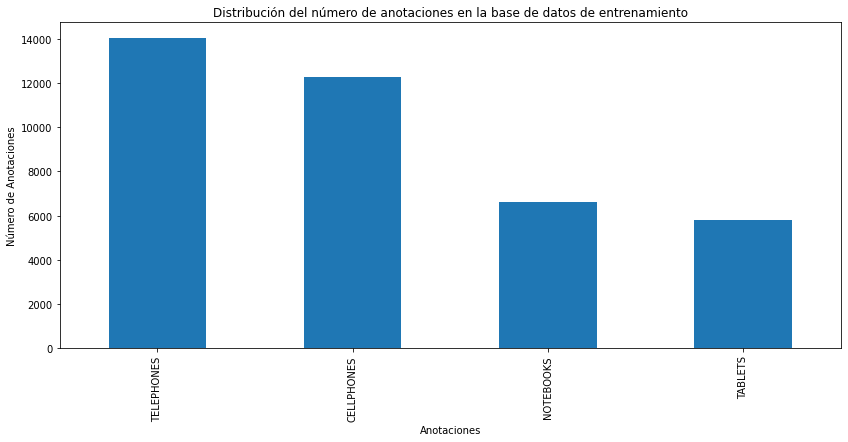

In [53]:
ax = productos_train['labels'].value_counts().plot(kind ='bar',figsize = (14,6))
ax.set_xlabel('Anotaciones')
ax.set_ylabel('Número de Anotaciones')
ax.set_title('Distribución del número de anotaciones en la base de datos de entrenamiento')

### Número de labels para cada categoría  en la base de datos de entrenamiento.

In [54]:
productos_train['labels'].value_counts()

TELEPHONES    14037
CELLPHONES    12253
NOTEBOOKS      6615
TABLETS        5800
Name: labels, dtype: int64

###  De la anterior gráfica se puede evidenciar que existe un mayor número de anotaciones de las clases *telephones* y *cellphones*. 

Text(0.5, 1.0, 'Distribución del número de anotaciones en la base de datos de validación.')

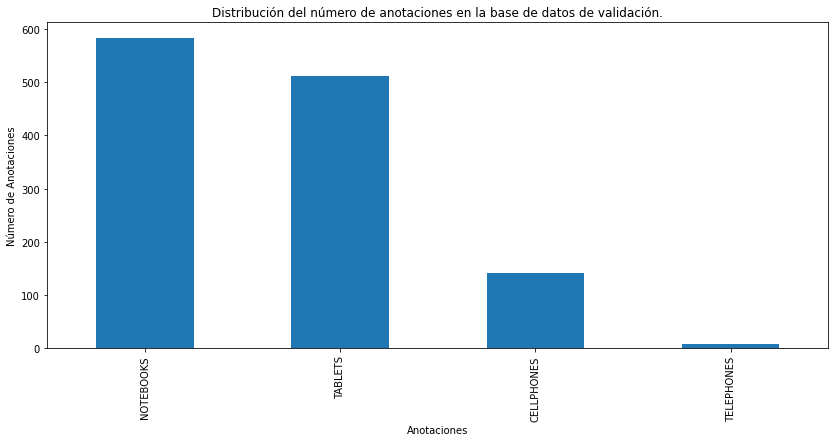

In [55]:
ax = productos_val['labels'].value_counts().plot(kind ='bar',figsize = (14,6))
ax.set_xlabel('Anotaciones')
ax.set_ylabel('Número de Anotaciones')
ax.set_title('Distribución del número de anotaciones en la base de datos de validación.')


### Número de labels para cada categoría  en la base de datos de validación.

In [56]:
productos_val['labels'].value_counts()

NOTEBOOKS     583
TABLETS       512
CELLPHONES    141
TELEPHONES      9
Name: labels, dtype: int64

### 2) Distribución de la validación por humanos para los dos conjuntos de datos 

Text(0.5, 1.0, 'Distribución de las validaciones')

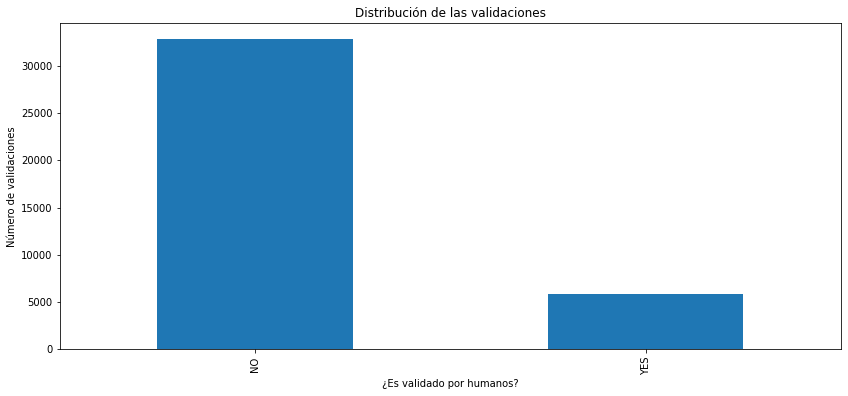

In [57]:
ax = productos_train['is_validated_by_humans'].value_counts().plot(kind ='bar',figsize = (14,6))
ax.set_xlabel('¿Es validado por humanos?')
ax.set_ylabel('Número de validaciones')
ax.set_title('Distribución de las validaciones')

### Número de anotaciones validadas por humanos en la base de datos de entrenamiento

In [58]:
productos_train.is_validated_by_humans.value_counts()

NO     32892
YES     5813
Name: is_validated_by_humans, dtype: int64

Text(0.5, 1.0, 'Distribución de las validaciones')

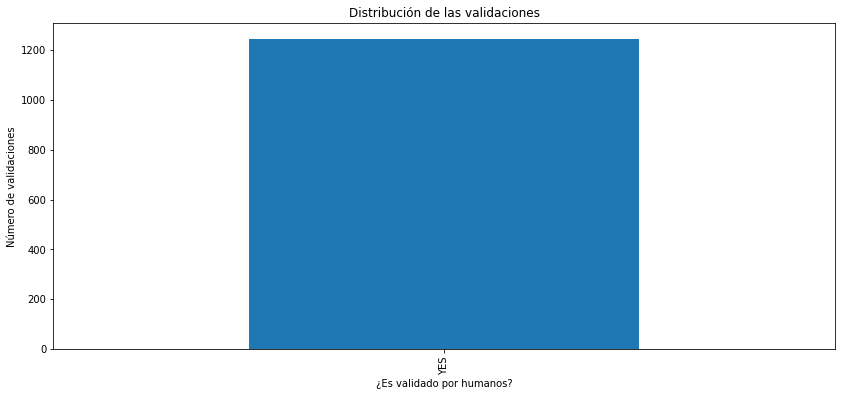

In [59]:
ax = productos_val['is_validated_by_humans'].value_counts().plot(kind ='bar',figsize = (14,6))
ax.set_xlabel('¿Es validado por humanos?')
ax.set_ylabel('Número de validaciones')
ax.set_title('Distribución de las validaciones')

### Número de anotaciones validadas por humanos en la base de datos de validación

In [60]:
productos_val.is_validated_by_humans.value_counts()

YES    1245
Name: is_validated_by_humans, dtype: int64

### Por último y por facilidad de manejo de los datos se crearon dos archivos csv nuevos en los cuales ya se encuentran los datos limpios. 

In [61]:
productos_train.to_csv('new_train.csv', encoding='utf-8', index=False)

In [62]:
productos_val.to_csv('new_val.csv', encoding='utf-8', index=False)

# A PARTIR DE ESTE PUNTO SE TRABAJA CON LOS NUEVOS ARCHIVOS CSV 

In [63]:
train_data = pd.read_csv('new_train.csv')
train_data = train_data[train_data['title'].notna()]
train_data.head()
train_data.isnull().sum()

title                     0
labels                    0
is_validated_by_humans    0
dtype: int64

In [64]:
val_data = pd.read_csv('new_val.csv')
val_data.head() 
val_data.isnull().sum()

title                     0
labels                    0
is_validated_by_humans    0
dtype: int64

In [65]:
#%% UN MÉTODO PARA LA MATRIZ DE CONFUSIÓN 
col = ['labels','title']
train_data = train_data[col]
train_data.columns = ['labels','title']
train_data['labels_id'] = train_data['labels'].factorize()[0] # pasamos los labels a números del 0 al 3 

labels_id_train_data = train_data[['labels','labels_id']].drop_duplicates().sort_values('labels_id')
labels_to_id = dict(labels_id_train_data.values)
id_to_labels = dict(labels_id_train_data[['labels_id','labels']].values)

## TAREA 1 OBSERVACIONES Y CONCLUSIONES:

Teniendo en cuenta el análisis exploratorio de los datos se concluyó:

1. En el dataset original se tenian varios registros nulos en las columnas de *title* y *is_validated_by_human*. A partir de esto decidí no eliminar dichos registros de la base de datos ya que consideré que era una proporción considerable del número total de registros *( 4265 de 38705)* *11% de la base de datos original*. 

1.1 Aclarado el punto anterior, encontré que en la columna *label* se encontraba toda la información del correspondiente registro como por ejemplo *columna label = TABLETS,"Manzana iPad Pro (11 Pulgada , Wi Fi, 1tb) - Gris Espacio",NO;;; *.Por lo tanto desarrollé un método para separar ese caracter en subcaracteres y asignar cada subcaracter a su columna correspondiente. Por último, en la columna *title* se arreglaron los títulos de los productos  para eliminar caracteres no necesarios como por ejemplo * ° | / *, stopwords, entre otros. 

2. Como segunda medida se analizaron los datos con diagramas de barras para evaluar la distribución de las anotaciones *label* y la validación de dichas anotaciones por humanos *is_validated_by_human*. Esto trajo consigo dos observaciones importantes:  

2.1 En cuanto a las anotaciones de la base de datos se encontró que esta se estaba desbalanceada, es decir que se tenían más ejemplos de entrenamiento de una clase que de otras, específicamente * telephones y cellphones* tenían un porcentaje mayor de registros en comparación de *tables y notebooks*. Esto era posible tratarlo con un rebalanceo de los datos, haciendo uso de un *undersampling (bajar la cantidad de registros para las clases con mayor cantidad)* o con un * oversampling (aumentar la cantidad de samples de los registros con menor número de anotaciones)*.  Sin embargo como primera medida se decidió no llevar a cabo ninguna de estas técnicas y dejar la proporción de anotaciones tal como se encontraba. * ESTE PUNTO SE CONFIRMA MÁS ADELANTE EN LA TAREA# 3*

2.2 En la base de datos se contaba con la columna que especificaba si la anotación de cada registro había sido validada por humanos. Decidí no tener en cuenta esta columna para el análisis de los datos o un posible rebalanceo porque : 

2.2.1  En el pdf de las instrucciones del proyecto  se especificaba que se llevara a cabo el entrenamiento del algoritmo solo con la columna del título del producto, por lo tanto este sería un feature que no influiria en el aprendizaje del modelo. 

2.2.2 Se hubiese podido rebalancear la base de datos de entrenamiento haciendo uso de  solo los datos que fueron validados por humanos. Sin embargo, estos solo representan  el *15%* de la base de datos de train. Es por ello, que se decidió dejar esta columna para el análisis de los datos pero en el entrenamiento de los modelos se dejó a un lado. Igualmente, cómo lo explican los datascientist de la empresa *[ManoMano](https://medium.com/manomano-tech/product-categorization-classical-machine-learning-problem-for-a-difficult-e-commerce-task-b5a9039d884b)*  ellos se enfrentaron a un problema similar dentro de su empresa y concluyeron que al eliminar los datos no validados por humanos, la base de datos tendría una mayor *'confianza o reabilidad'* de los datos pero una menor *representatividad*. Teniendo en cuenta esto, para los modelos de machine learning es importante que se expongan a bases de datos las cuales sean una representación fiable de los datos en la vida real.   
 


# Tarea# 2: PROCESAMIENTO DE LOS DATOS Y ENTRENAMIENTO DEL MEJOR MODELO.  

### Se utilizaron diferentes modelos para la clasificación de los títulos de los productos. Los modelos más usados según la literatura para abordar este problema son:

1. Naive Bayes Multinomial.
2. Regresión Logística.
3. Clasificador con descenso del gradiente. 
4. XGBOOST
5. Multilayer Perceptron. 


In [66]:
# Datos para el entrenamiento y la prueba 
X_train = train_data['title']
y_train = train_data['labels']
X_test = val_data['title']
y_test = val_data['labels']

 # PROCESAMIENTO DE LOS DATOS 

Como se explicó en la sección anterior, los datos , * título del producto*, se procesaron eliminando los caracteres no necesarios dentro de ellos. Esto debido a que a la hora de representar el texto del título del producto como valores continuos que los modelos pueden entender, dichos caracteres innecesarios causarían ruido dentro del procesamiento de los datos y también aumentarían el tiempo que se tarda en procesar cada uno de ellos. 

A partir de esto, investigué cual era la forma en la que se representaban los textos para este problema de clasificación multiclase. Encontré que uno de los métodos más usados es el TFIDF *(Term Frecuency Inverse Document Frecuency)* score. Este método consiste en llevar a cabo los  siguientes pasos:


Se calcula el TF *Time Frecuency* el cual es que tan común es que aparezca una palabra dentro del documento. 

 TF = $\frac{N.D}{T.W.D}$ 

 *N.D* = número de veces que aparece la palabra dentro del documento *(título del producto en nuestro caso)*.

 *T.W.D* = número total de palabras dentro del documento. 


 Se calcula el IDF *Inverse Document Frecuency* esto lo que hace es como un tipo de penalización para las palabras que aparecen dentro de muchos documentos. Si la palabra aparece dentro de muchos documentos este valor será menor y por lo tanto menos relevante es la palabra. 

 
IDF =  ln($\frac{N.D}{T.W.D}$)

Al final ambas cantidades se multiplican para obtener el TFIDF de la correspondiente palabra. Con esto lo que se logra es darle un mayor peso a  aquellas palabras que son más relevantes dentro de un documento como en el caso del dataset *IPAD, IPHONE* etc y le damos un menor valor aquellas palabras no tan relevantes como por ejemplo  *gb (gigabytes) o 'al' 'de'* etc.



Para esto se hizo uso de la función *tfidfVectortizer* de *sklearn*. Esta función  lleva a cabo primero una vectorización del título del producto con respecto a la frecuencia de cada una de las palabras. Luego a dicho vector se le aplica el proceso del TFIDF y se obtienen los respectivos valores explicados anteriormente. 

Por último, los parámetros que se le pasan a la función  *tfidfVectortizer* corresponden a lo siguiente:

1. sublinear = True *(calcular la frecuencia de forma logarítmica)*
2. min_dif = 5 *( mínimo número de documentos en donde la palabra debe aparecer para ser tenida en cuenta)*
3. norm = 'l2' *(todos los features tienen una norma euclidiana de 1)* 
4. ngram_range = (1,2) *( considera tanto unigramas como bigramas )* 
5. stopwords = 'spanish' *( remover los pronombres comunes en español como 'a','el', 'de' etc )*


# MODELOS MACHINE LEARNING :

## NAIVE BAYES MULTINOMIAL 

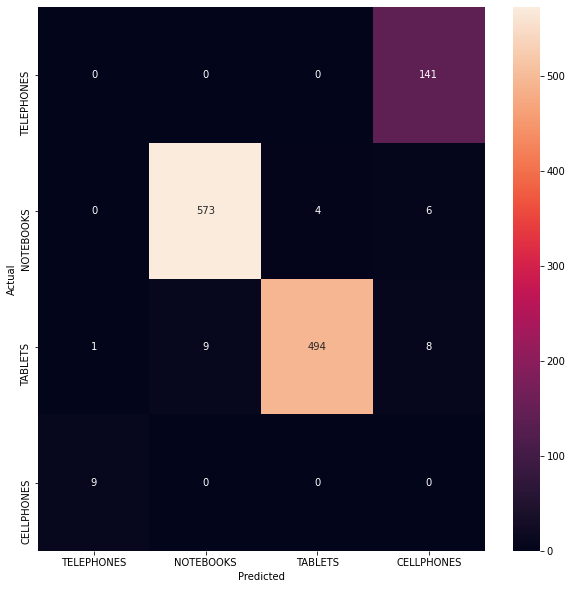

              precision    recall  f1-score   support

  TELEPHONES       0.00      0.00      0.00       141
   NOTEBOOKS       0.98      0.98      0.98       583
     TABLETS       0.99      0.96      0.98       512
  CELLPHONES       0.00      0.00      0.00         9

    accuracy                           0.86      1245
   macro avg       0.49      0.49      0.49      1245
weighted avg       0.87      0.86      0.86      1245

 El accuracy para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es: 0.8570281124497992
 La precisión para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es: 0.868973563279741
 La cobertura para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es: 0.8570281124497992
 El UNO-vs-UNO ROC AUC score:
0.692372 (macro),
0.829404 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.781471 (macro),
0.969788 (pesado por prevalencia de las clases)


In [67]:
# Entrenamiento del modelo.
nb = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es:",metrics.accuracy_score(y_test, y_pred))
print(" La precisión para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es:",metrics.precision_score(y_test, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es:",metrics.recall_score(y_test, y_pred,average='weighted'))

y_prob = nb.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## REGRESIÓN LOGÍSTICA 

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


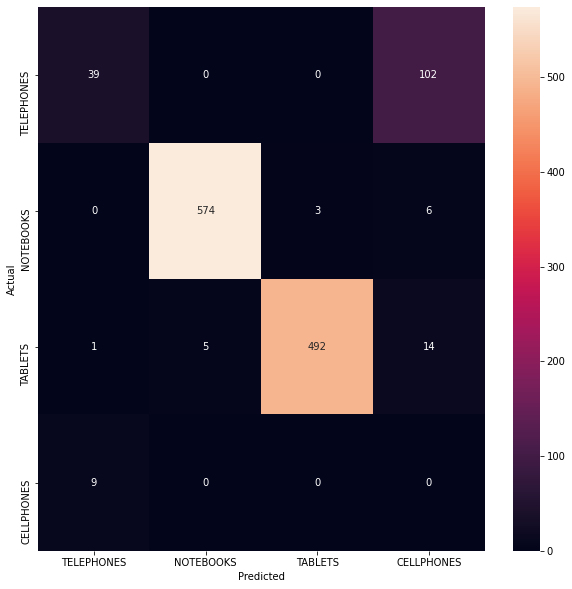

              precision    recall  f1-score   support

  TELEPHONES       0.80      0.28      0.41       141
   NOTEBOOKS       0.99      0.98      0.99       583
     TABLETS       0.99      0.96      0.98       512
  CELLPHONES       0.00      0.00      0.00         9

    accuracy                           0.89      1245
   macro avg       0.70      0.56      0.59      1245
weighted avg       0.96      0.89      0.91      1245

 El accuracy para el modelo haciendo uso de la regresión logística es: 0.8875502008032129
 La precisión para el modelo haciendo uso de la regresión logística es: 0.963122021830163
 La cobertura para el modelo haciendo uso de la regresión logística es es: 0.8875502008032129
 El UNO-vs-UNO ROC AUC score:
0.755247 (macro),
0.884902 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.858506 (macro),
0.988897 (pesado por prevalencia de las clases)


In [68]:
# Entrenamiento del modelo.
logreg = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', LogisticRegression(solver = 'liblinear',multi_class = 'ovr',n_jobs=1, C=1e5)),
              ])

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de la regresión logística es:",metrics.accuracy_score(y_test, y_pred))
print(" La precisión para el modelo haciendo uso de la regresión logística es:",metrics.precision_score(y_test, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso de la regresión logística es es:",metrics.recall_score(y_test, y_pred,average='weighted'))

y_prob = logreg.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Clasificador con descenso del gradiente

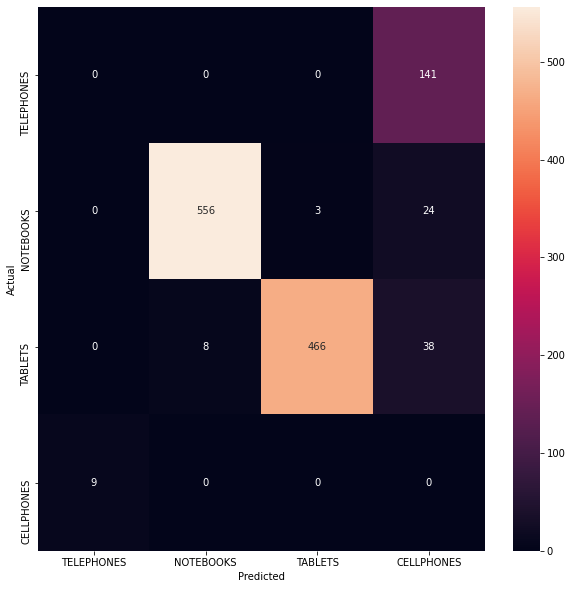

              precision    recall  f1-score   support

  TELEPHONES       0.00      0.00      0.00       141
   NOTEBOOKS       0.99      0.95      0.97       583
     TABLETS       0.99      0.91      0.95       512
  CELLPHONES       0.00      0.00      0.00         9

    accuracy                           0.82      1245
   macro avg       0.49      0.47      0.48      1245
weighted avg       0.87      0.82      0.84      1245

 El accuracy para el modelo haciendo uso del clasificador con descenso del gradiente es: 0.8208835341365461
 La precisión para el modelo haciendo uso del clasificador con descenso del gradiente es: 0.870245335862648
 La cobertura para el modelo haciendo uso del clasificador con descenso del gradiente es: 0.8208835341365461
 El UNO-vs-UNO ROC AUC score:
0.667079 (macro),
0.797795 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.739171 (macro),
0.947939 (pesado por prevalencia de las clases)


In [69]:
# Entrenamiento del modelo.
sgd  = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', SGDClassifier(loss= 'log', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
              ])

sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso del clasificador con descenso del gradiente es:",metrics.accuracy_score(y_test, y_pred))
print(" La precisión para el modelo haciendo uso del clasificador con descenso del gradiente es:",metrics.precision_score(y_test, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso del clasificador con descenso del gradiente es:",metrics.recall_score(y_test, y_pred,average='weighted'))

y_prob = sgd.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## XGBOOST 

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[12:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "learn_rate", "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




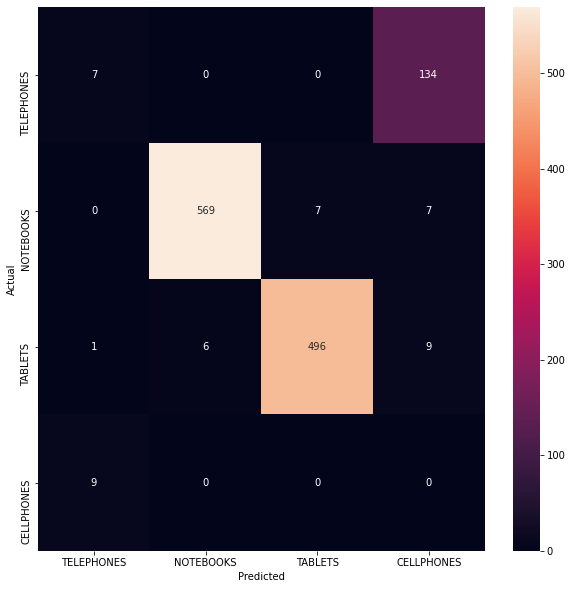

              precision    recall  f1-score   support

  TELEPHONES       0.41      0.05      0.09       141
   NOTEBOOKS       0.99      0.98      0.98       583
     TABLETS       0.99      0.97      0.98       512
  CELLPHONES       0.00      0.00      0.00         9

    accuracy                           0.86      1245
   macro avg       0.60      0.50      0.51      1245
weighted avg       0.92      0.86      0.87      1245

 El accuracy para el modelo haciendo uso de XGBOOST es: 0.8610441767068273
 La precisión para el modelo haciendo uso de XGBOOST es: 0.9155422463932497
 La cobertura para el modelo haciendo uso de XGBOOST es: 0.8610441767068273
 El UNO-vs-UNO ROC AUC score:
0.808303 (macro),
0.936493 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.935579 (macro),
0.994148 (pesado por prevalencia de las clases)


In [70]:
# Entrenamiento del modelo.
clf_xgb = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', XGBClassifier( random_state=42,objective = 'reg:logistic',learn_rate = 0.05, gamma = 0.25, max_depth = 5, reg_lambda = 1, scale_pos_weight = 3, seed=2, colsample_bytree=0.6, subsample=0.7)),
              ])

clf_xgb.fit(X_train, y_train,clf__verbose = True,clf__eval_metric = 'aucpr')

y_pred = clf_xgb.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de XGBOOST es:",metrics.accuracy_score(y_test, y_pred))
print(" La precisión para el modelo haciendo uso de XGBOOST es:",metrics.precision_score(y_test, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso de XGBOOST es:",metrics.recall_score(y_test, y_pred,average='weighted'))

y_prob = clf_xgb.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Multilayer Perceptron Classifier 

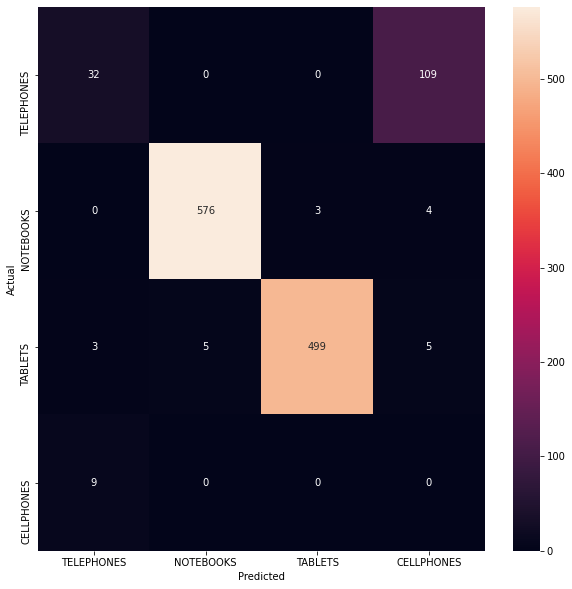

              precision    recall  f1-score   support

  TELEPHONES       0.73      0.23      0.35       141
   NOTEBOOKS       0.99      0.99      0.99       583
     TABLETS       0.99      0.97      0.98       512
  CELLPHONES       0.00      0.00      0.00         9

    accuracy                           0.89      1245
   macro avg       0.68      0.55      0.58      1245
weighted avg       0.96      0.89      0.91      1245

 El accuracy para el modelo haciendo uso del multi layer perceptron es: 0.8891566265060241
 La precisión para el modelo haciendo uso del multi layer perceptron es: 0.9553963709922254
 La cobertura para el modelo haciendo uso del multi layer perceptron es: 0.8891566265060241
 El UNO-vs-UNO ROC AUC score:
0.738855 (macro),
0.872939 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.842424 (macro),
0.986094 (pesado por prevalencia de las clases)


In [72]:
# Entrenamiento del modelo.
mlp  = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', MLPClassifier(activation = 'relu',solver = 'adam',random_state=1, max_iter=300)),
              ])

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso del multi layer perceptron es:",metrics.accuracy_score(y_test, y_pred))
print(" La precisión para el modelo haciendo uso del multi layer perceptron es:",metrics.precision_score(y_test, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso del multi layer perceptron es:",metrics.recall_score(y_test, y_pred,average='weighted'))

y_prob = mlp.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

# MEJOR MODELO  - REGRESIÓN LOGÍSTICA 
## Otro modelo de  regresión logística pero haciendo uso de otro esquema de entrenamiento multiclase (*multinomial*) y algoritmo de optimización (*sag*).

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


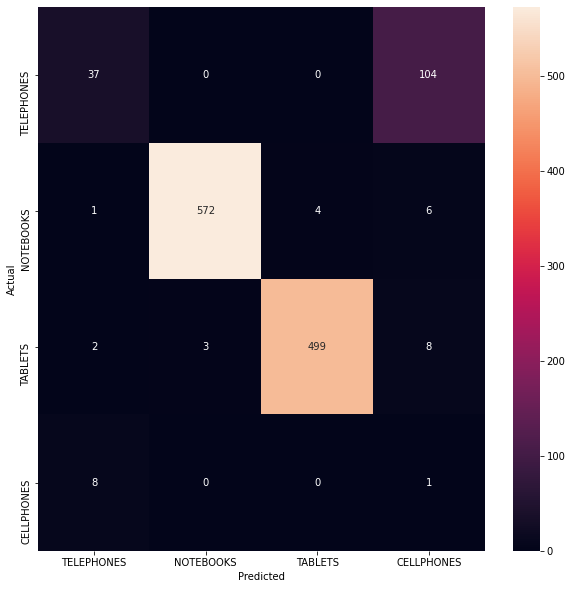

              precision    recall  f1-score   support

  TELEPHONES       0.77      0.26      0.39       141
   NOTEBOOKS       0.99      0.98      0.99       583
     TABLETS       0.99      0.97      0.98       512
  CELLPHONES       0.01      0.11      0.02         9

    accuracy                           0.89      1245
   macro avg       0.69      0.58      0.59      1245
weighted avg       0.96      0.89      0.91      1245

 El accuracy para el modelo haciendo uso de la regresión logística es: 0.8907630522088353
 La precisión para el modelo haciendo uso de la regresión logística es: 0.9611645144940766
 La cobertura para el modelo haciendo uso de la regresión logística es es: 0.8907630522088353
 El UNO-vs-UNO ROC AUC score:
0.764798 (macro),
0.891443 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.868105 (macro),
0.988485 (pesado por prevalencia de las clases)


In [94]:
# Entrenamiento del modelo.
logreg2 = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', LogisticRegression(solver = 'sag',multi_class = 'multinomial',n_jobs=1, C=1e5)),
              ])

logreg2.fit(X_train, y_train)

dump(logreg2,'model_logreg.joblib')

y_pred = logreg2.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de la regresión logística es:",metrics.accuracy_score(y_test, y_pred))
print(" La precisión para el modelo haciendo uso de la regresión logística es:",metrics.precision_score(y_test, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso de la regresión logística es es:",metrics.recall_score(y_test, y_pred,average='weighted'))

y_prob = logreg2.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Conclusión de los modelos propuestos:

De los modelos anteriores se concluyó lo siguiente:

1. El Naive bayes multinomial y el clasificador con descenso del gradiente son bastante sensibles al desbalance de clases presente tanto en el conjunto de entrenamiento como en el de validación. 

2. Existe un rendimiento cercano entre los modelos de regresión logística, multilayer preceptron y el XGBOOST. Además de esto, dichos modelos no son tan sensibles al desbalance de clases. Sin embargo ninguno de ellos logro predecir adecuadamente la categoría de cellphones dentro del conjunto de validación. Esto me lleva a indicar que el desbalance de clases al final y al cabo no era algo que afectara el proceso de entrenamiento de  los algoritmos de forma significativa. 


# TAREA #3 : Evaluación del modelo. 

En este punto se definió que el mejor modelo era la regresión logística por lo tanto se hizo uso de esta para obtener las métricas y la matriz de confusión con respecto a los datos de validación 

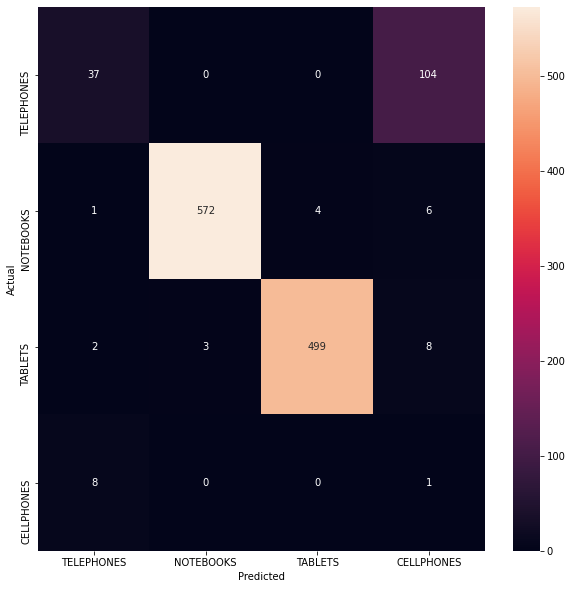

              precision    recall  f1-score   support

  TELEPHONES       0.77      0.26      0.39       141
   NOTEBOOKS       0.99      0.98      0.99       583
     TABLETS       0.99      0.97      0.98       512
  CELLPHONES       0.01      0.11      0.02         9

    accuracy                           0.89      1245
   macro avg       0.69      0.58      0.59      1245
weighted avg       0.96      0.89      0.91      1245

 El accuracy para el modelo haciendo uso de la regresión logística es: 0.8907630522088353
 La precisión para el modelo haciendo uso de la regresión logística es: 0.9611645144940766
 La cobertura para el modelo haciendo uso de la regresión logística es es: 0.8907630522088353
 El UNO-vs-UNO ROC AUC score:
0.764798 (macro),
0.891443 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.868105 (macro),
0.988485 (pesado por prevalencia de las clases)


In [95]:
final_model = load('model_logreg.joblib')
y_pred = final_model.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de la regresión logística es:",metrics.accuracy_score(y_test, y_pred))
print(" La precisión para el modelo haciendo uso de la regresión logística es:",metrics.precision_score(y_test, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso de la regresión logística es es:",metrics.recall_score(y_test, y_pred,average='weighted'))

y_prob = final_model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

 ### Dado a que se tenía un desbalance de las clases, para hacer un análisis más adecuado del performance de los modelos es mejor guiarse por las métricas de la precisión y la cobertura así como el ROC AUC. Esta última se calcula a partir de la tasa de verdaderos positivos y falsos positivos. 
 
 ### Cabe aclarar que como se trata de un problema multiclase, se debe calcular el ROC AUC de dos formas, una de ellas con el método de *OVO* *( One vs One)*  y otra con el método de *OvR* *( One vs Rest)*.Con base en esto, y en la precisión	y cobertura para cada una de las clases por separado se determinó que el mejor modelo era la regresión logística. 

# CONCLUSIÓN FINAL Y CONSIDERACIONES FUTURAS: 

En este proyecto se desarrolló un algoritmo de clasificación multiclase para una base de datos de productos. Se analizaron y limpiaron los datos,luego se llevaron a un espacio de representación para que de esta forma un modelo de machine learning pudiese predecir la clase a la cual pertenecía cierto producto. 

Este modelo se podría utilizar en una tienda e-commerce, así como puede ser utilizado por 1doc3 para la clasificación del mensaje de entrada de un usuario en la plataforma para así referirlo al correspondiente médico que trate afecciones de dicha categoría. 

Mi modelo de regresión logística no tiene el 100% de las predicciones correctas, sin embargo considero que el performance que alcanzó es bastante aceptable dentro del rango de tiempo para la tarea.

Por mi parte intenté aplicar un modelo de deeplearning llamado *BERT*, sin embargo dadas mis limitaciones computacionales no me fue posible mostrar los resultados de este algoritmo ya que es bastante pesado a pesar de que en pytorch utilizé un modelo ya preentrenado. Me tomaba bastante tiempo entrenar la última capa del modelo y luego probarlo. Pero según revisé en la literatura este es uno de los métodos que son el estado del arte en el NLP.  

Finalmente, en el enunciado del proyecto no se especifica si queremos que el modelo tenga una mayor precisión o cobertura con respecto a las predicciones. Por lo tanto, y teniendo en cuenta el desbalance de las clases, consideré darle más peso a la precisión del modelo así como al ROC_AUC score. 





# ANEXO ( DESARROLLO DEL MODELO CON TRAIN, VAL Y TEST)

## En este apartado presento el mismo desarrollo anterior, sin embargo en este punto hago uso de un subconjunto de los datos de train como conjunto de datos para la validación. Esto debido a que el enunciado del proyecto me confunde un poco y no se si al final podía hacer uso un subconjunto de validación. Por lo tanto la división de la base de datos, para este apartado, queda de la siguiente manera:

### Partiendo del archivo original *'Train.csv'* este se dividió en dos partes : *80%* para entrenar los modelos y *20%* para la validación de los mismos. 

### El archivo original *'Val.csv'* se dejo tal cual y este vendría siendo el nuevo *TEST* tal como se hizo en los apartados anteriores y como se especifica en el PDF del proyecto.



In [73]:
train_data = pd.read_csv('new_train.csv')
train_data = train_data[train_data['title'].notna()]
train_data.head()
train_data.isnull().sum()

title                     0
labels                    0
is_validated_by_humans    0
dtype: int64

In [75]:
# este es archivo original 'val' después de limpiarlo. 
test_data = pd.read_csv('new_val.csv')
test_data.head() 
test_data.isnull().sum()

title                     0
labels                    0
is_validated_by_humans    0
dtype: int64

In [86]:
#%% UN MÉTODO PARA LA MATRIZ DE CONFUSIÓN 
col = ['labels','title']
train_data = train_data[col]
train_data.columns = ['labels','title']
train_data['labels_id'] = train_data['labels'].factorize()[0] # pasamos los labels a números del 0 al 3 

labels_id_train_data = train_data[['labels','labels_id']].drop_duplicates().sort_values('labels_id')
print(labels_id_train_data.labels.values)
labels_to_id = dict(labels_id_train_data.values)
id_to_labels = dict(labels_id_train_data[['labels_id','labels']].values)

['TELEPHONES' 'NOTEBOOKS' 'TABLETS' 'CELLPHONES']


In [77]:
# Datos para el entrenamiento y la prueba 
X = train_data['title']
y = train_data['labels']
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.20, random_state = 0)

In [97]:
X_test = test_data['title']
y_test = test_data['labels']

### A partir de este punto se entrenará el modelo con X_train, y_train. Se harán las predicciones con X_val y por último se evaluarán dichas predicciones con y_val. 

#### Luego de esto, el mejor modelo se evaluará finalmente haciendo las predicciones con X_test y comparandolas con y_test. 

## Naive Bayes Multinomial 

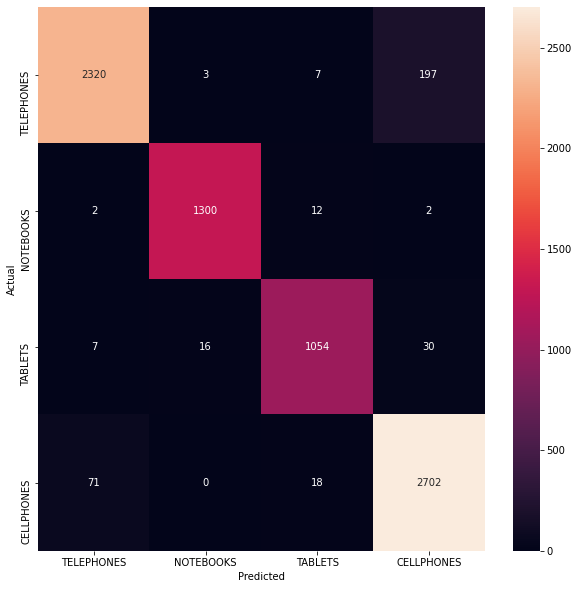

              precision    recall  f1-score   support

  TELEPHONES       0.97      0.92      0.94      2527
   NOTEBOOKS       0.99      0.99      0.99      1316
     TABLETS       0.97      0.95      0.96      1107
  CELLPHONES       0.92      0.97      0.94      2791

    accuracy                           0.95      7741
   macro avg       0.96      0.96      0.96      7741
weighted avg       0.95      0.95      0.95      7741

 El accuracy para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es: 0.9528484691900271
 La precisión para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es: 0.9536501105938828
 La cobertura para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es: 0.9528484691900271
 El UNO-vs-UNO ROC AUC score:
0.990267 (macro),
0.988204 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.987747 (macro),
0.983788 (pesado por prevalencia de las clases)


In [96]:
# Entrenamiento del modelo.
nb = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, y_train)

dump(nb,'model_nbm.joblib')

y_pred = nb.predict(X_val)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_val, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es:",metrics.accuracy_score(y_val, y_pred))
print(" La precisión para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es:",metrics.precision_score(y_val, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso del NAIVE BAYES MULTINOMIAL es:",metrics.recall_score(y_val, y_pred,average='weighted'))

y_prob = nb.predict_proba(X_val)

macro_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Regresión logística # 1 

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


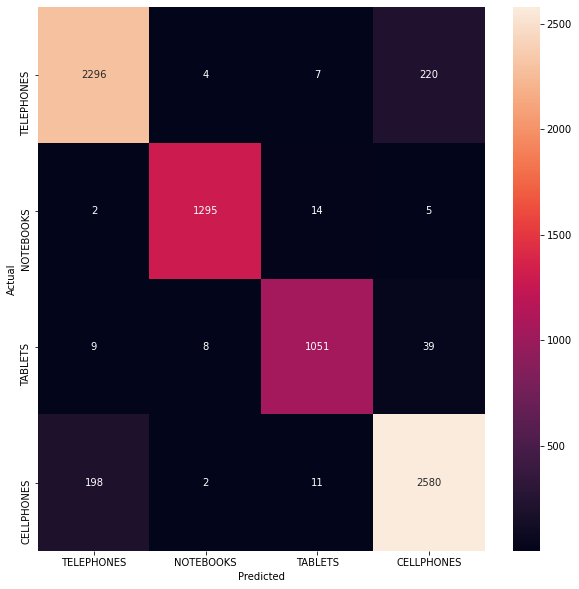

              precision    recall  f1-score   support

  TELEPHONES       0.92      0.91      0.91      2527
   NOTEBOOKS       0.99      0.98      0.99      1316
     TABLETS       0.97      0.95      0.96      1107
  CELLPHONES       0.91      0.92      0.92      2791

    accuracy                           0.93      7741
   macro avg       0.95      0.94      0.94      7741
weighted avg       0.93      0.93      0.93      7741

 El accuracy para el modelo haciendo uso de la regresión logística es: 0.9329543986565043
 La precisión para el modelo haciendo uso de la regresión logística es: 0.9332515559613892
 La cobertura para el modelo haciendo uso de la regresión logística es: 0.9329543986565043
 El UNO-vs-UNO ROC AUC score:
0.989605 (macro),
0.987669 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.987309 (macro),
0.983611 (pesado por prevalencia de las clases)


In [89]:
# Entrenamiento del modelo.
logreg = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', LogisticRegression(solver = 'liblinear',multi_class = 'ovr',n_jobs=1, C=1e5)),
              ])

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_val)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_val, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de la regresión logística es:",metrics.accuracy_score(y_val, y_pred))
print(" La precisión para el modelo haciendo uso de la regresión logística es:",metrics.precision_score(y_val, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso de la regresión logística es:",metrics.recall_score(y_val, y_pred,average='weighted'))

y_prob = logreg.predict_proba(X_val)

macro_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Regresión logística #2  (ESTE ES EL MEJOR MODELO DEL PRIMER ESQUEMA DE ENTRENAMIENTO)

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


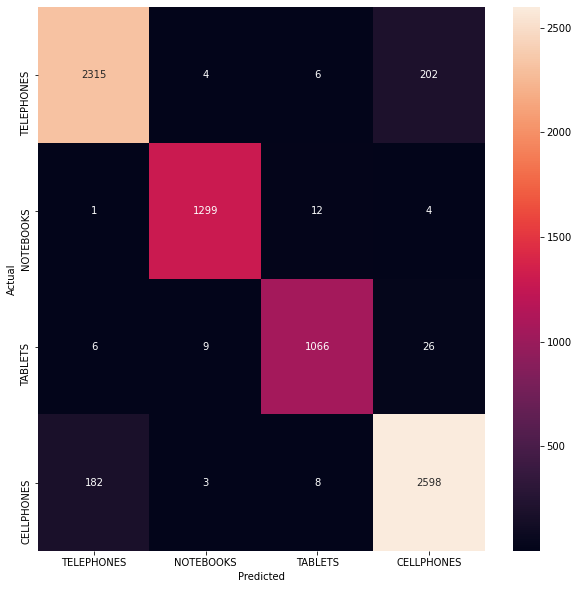

              precision    recall  f1-score   support

  TELEPHONES       0.92      0.92      0.92      2527
   NOTEBOOKS       0.99      0.99      0.99      1316
     TABLETS       0.98      0.96      0.97      1107
  CELLPHONES       0.92      0.93      0.92      2791

    accuracy                           0.94      7741
   macro avg       0.95      0.95      0.95      7741
weighted avg       0.94      0.94      0.94      7741

 El accuracy para el modelo haciendo uso de la regresión logística # 2 es: 0.9401886061232398
 La precisión para el modelo haciendo uso de la regresión logística # 2 es: 0.9403296525801751
 La cobertura para el modelo haciendo uso de la regresión logística # 2 es: 0.9401886061232398
 El UNO-vs-UNO ROC AUC score:
0.992398 (macro),
0.990801 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.990395 (macro),
0.987455 (pesado por prevalencia de las clases)


In [90]:
# Entrenamiento del modelo.
logreg2 = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', LogisticRegression(solver = 'sag',multi_class = 'multinomial',n_jobs=1, C=1e5)),
              ])

logreg2.fit(X_train, y_train)

y_pred = logreg2.predict(X_val)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_val, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de la regresión logística # 2 es:",metrics.accuracy_score(y_val, y_pred))
print(" La precisión para el modelo haciendo uso de la regresión logística # 2 es:",metrics.precision_score(y_val, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso de la regresión logística # 2 es:",metrics.recall_score(y_val, y_pred,average='weighted'))

y_prob = logreg2.predict_proba(X_val)

macro_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Clasificador con descenso del gradiente. 

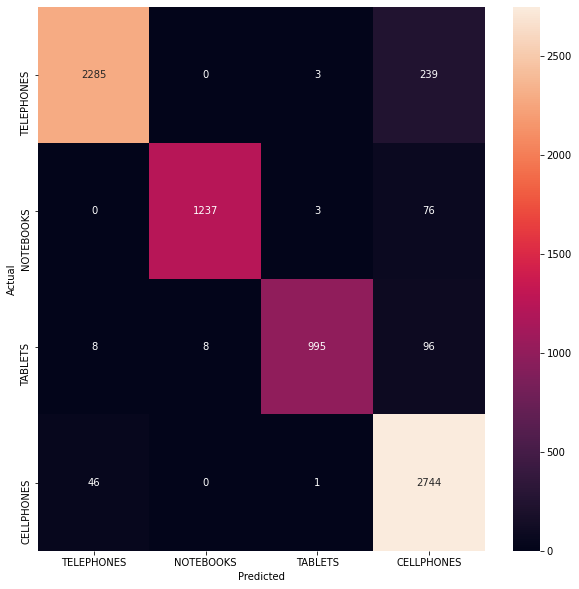

              precision    recall  f1-score   support

  TELEPHONES       0.98      0.90      0.94      2527
   NOTEBOOKS       0.99      0.94      0.97      1316
     TABLETS       0.99      0.90      0.94      1107
  CELLPHONES       0.87      0.98      0.92      2791

    accuracy                           0.94      7741
   macro avg       0.96      0.93      0.94      7741
weighted avg       0.94      0.94      0.94      7741

 El accuracy para el modelo haciendo uso de SGD es: 0.9379925074279809
 La precisión para el modelo haciendo uso de SGD es: 0.9434036936252119
 La cobertura para el modelo haciendo uso de SGD es: 0.9379925074279809
 El UNO-vs-UNO ROC AUC score:
0.988350 (macro),
0.986445 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.986489 (macro),
0.982297 (pesado por prevalencia de las clases)


In [91]:
# Entrenamiento del modelo.
sgd = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', SGDClassifier(loss= 'log', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
              ])

sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_val)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_val, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de SGD es:",metrics.accuracy_score(y_val, y_pred))
print(" La precisión para el modelo haciendo uso de SGD es:",metrics.precision_score(y_val, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso de SGD es:",metrics.recall_score(y_val, y_pred,average='weighted'))

y_prob = sgd.predict_proba(X_val)

macro_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## XGBOOST

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[15:41:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "learn_rate", "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




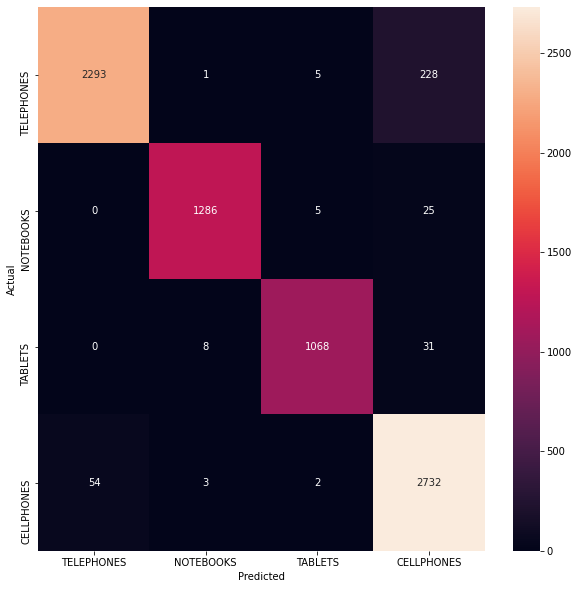

              precision    recall  f1-score   support

  TELEPHONES       0.98      0.91      0.94      2527
   NOTEBOOKS       0.99      0.98      0.98      1316
     TABLETS       0.99      0.96      0.98      1107
  CELLPHONES       0.91      0.98      0.94      2791

    accuracy                           0.95      7741
   macro avg       0.97      0.96      0.96      7741
weighted avg       0.96      0.95      0.95      7741

 El accuracy para el modelo haciendo uso de XGBOOST es: 0.9532360160186022
 La precisión para el modelo haciendo uso de XGBOOST es: 0.9553777464942278
 La cobertura para el modelo haciendo uso de XGBOOST es: 0.9532360160186022
 El UNO-vs-UNO ROC AUC score:
0.995062 (macro),
0.993890 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.993424 (macro),
0.991453 (pesado por prevalencia de las clases)


In [92]:
# Entrenamiento del modelo.
XGB = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', XGBClassifier( random_state=42,objective = 'reg:logistic',learn_rate = 0.05, gamma = 0.25, max_depth = 5, reg_lambda = 1, scale_pos_weight = 3, seed=2, colsample_bytree=0.6, subsample=0.7)),
              ])

XGB.fit(X_train, y_train,clf__verbose = True,clf__eval_metric = 'aucpr')

y_pred = XGB.predict(X_val)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_val, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de XGBOOST es:",metrics.accuracy_score(y_val, y_pred))
print(" La precisión para el modelo haciendo uso de XGBOOST es:",metrics.precision_score(y_val, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso de XGBOOST es:",metrics.recall_score(y_val, y_pred,average='weighted'))

y_prob = XGB.predict_proba(X_val)

macro_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Multi layer perceptron classifier. 

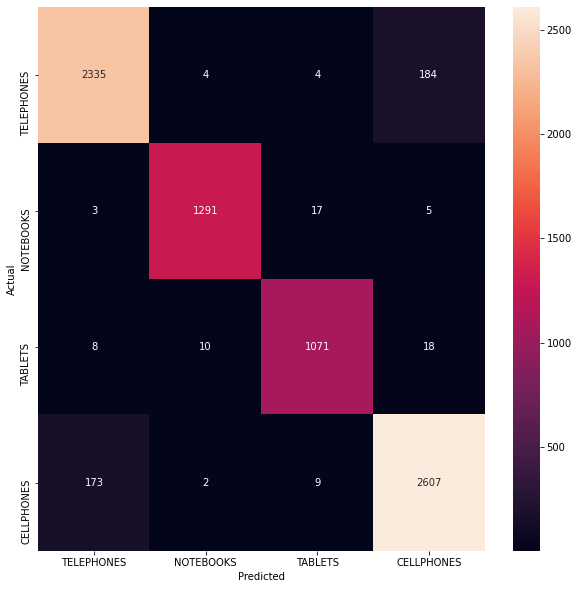

              precision    recall  f1-score   support

  TELEPHONES       0.93      0.92      0.93      2527
   NOTEBOOKS       0.99      0.98      0.98      1316
     TABLETS       0.97      0.97      0.97      1107
  CELLPHONES       0.93      0.93      0.93      2791

    accuracy                           0.94      7741
   macro avg       0.95      0.95      0.95      7741
weighted avg       0.94      0.94      0.94      7741

 El accuracy para el modelo haciendo uso del MLP es: 0.9435473453042242
 La precisión para el modelo haciendo uso del MLP es: 0.9436550671835783
 La cobertura para el modelo haciendo uso del MLP es: 0.9435473453042242
 El UNO-vs-UNO ROC AUC score:
0.991497 (macro),
0.989978 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.989909 (macro),
0.986759 (pesado por prevalencia de las clases)


In [93]:
# Entrenamiento del modelo.
MLP = Pipeline([
               ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, norm ='l2',encoding='latin-1',ngram_range = (1,2),stop_words = stopwords.words('spanish'))),
               ('clf', MLPClassifier(activation = 'relu',solver = 'adam',random_state=1, max_iter=300)),
              ])

MLP.fit(X_train, y_train)

y_pred = MLP.predict(X_val)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_val, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso del MLP es:",metrics.accuracy_score(y_val, y_pred))
print(" La precisión para el modelo haciendo uso del MLP es:",metrics.precision_score(y_val, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso del MLP es:",metrics.recall_score(y_val, y_pred,average='weighted'))

y_prob = MLP.predict_proba(X_val)

macro_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_val, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_val, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## En este caso quien obtuvo un mejor desempeño fue el Naive Bayes Classifier por lo tanto ese modelo fue el que se utilizó para hacer las predicciones en los datos de test. 

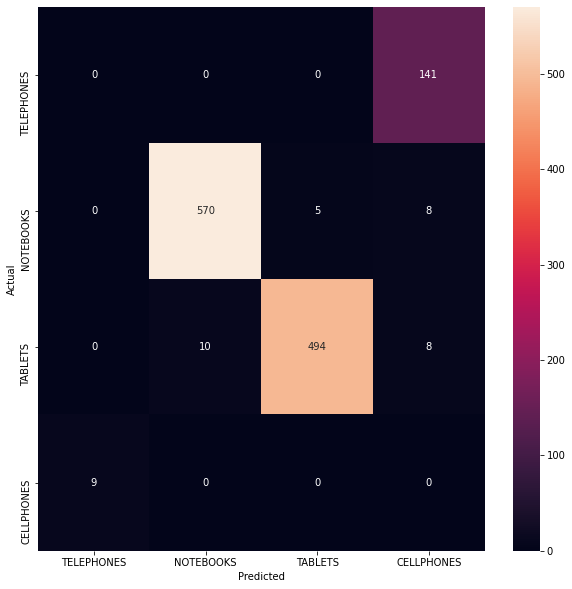

              precision    recall  f1-score   support

  TELEPHONES       0.00      0.00      0.00       141
   NOTEBOOKS       0.98      0.98      0.98       583
     TABLETS       0.99      0.96      0.98       512
  CELLPHONES       0.00      0.00      0.00         9

    accuracy                           0.85      1245
   macro avg       0.49      0.49      0.49      1245
weighted avg       0.87      0.85      0.86      1245

 El accuracy para el modelo haciendo uso de la regresión logística es: 0.8546184738955823
 La precisión para el modelo haciendo uso de la regresión logística es: 0.8673237071012264
 La cobertura para el modelo haciendo uso de la regresión logística es es: 0.8546184738955823
 El UNO-vs-UNO ROC AUC score:
0.692316 (macro),
0.828914 (pesado por prevalencia de las clases)
El Uno-vs-El RESTO ROC AUC score:
0.781077 (macro),
0.968465 (pesado por prevalencia de las clases)


In [98]:
final_model = load('model_nbm.joblib')
y_pred = final_model.predict(X_test)

# Matriz de confusión. 
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels_id_train_data.labels.values, yticklabels=labels_id_train_data.labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Métricas del modelo. 
print(metrics.classification_report(y_test, y_pred, target_names=train_data['labels'].unique()))
print(" El accuracy para el modelo haciendo uso de la regresión logística es:",metrics.accuracy_score(y_test, y_pred))
print(" La precisión para el modelo haciendo uso de la regresión logística es:",metrics.precision_score(y_test, y_pred,average='weighted'))
print(" La cobertura para el modelo haciendo uso de la regresión logística es es:",metrics.recall_score(y_test, y_pred,average='weighted'))

y_prob = final_model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print(" El UNO-vs-UNO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("El Uno-vs-El RESTO ROC AUC score:\n{:.6f} (macro),\n{:.6f} "
      "(pesado por prevalencia de las clases)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Este modelo Naive Bayes obtiene un rendimiento bastante bueno partiendo de las métricas de precisión y cobertura. Sin embargo, como se puede observar la categorías *telephones* y *cellphones* obtienen un porcentaje bastante deficiente en cuanto a su precisión y cobertura respectivamente. Es decir este modelo se ve afectado por el desbalance de las clases.

## Teniendo en cuenta todos los modelos presentados se concluye que el mejor modelo es el de regresión logística haciendo solo uso de un conjunto de entrenamiento y uno de prueba. 